# Modelling transcriptional regulation using GPs

This notebook defines the mean function used to model the latent force function which controls the expression levels of the 5 p53-modulated genes.

In [2]:
import numpy as np
import gpjax as gpx
import os
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from dataclasses import dataclass
import jax.random as jr
from jax import jit

from p53_dataset import JAXP53_Data, load_barenco_data, flatten_dataset_jax
jax.config.update('jax_enable_x64', True)

import matplotlib as mpl
from matplotlib import rcParams

plt.style.use("https://raw.githubusercontent.com/JaxGaussianProcesses/GPJax/main/docs/examples/gpjax.mplstyle")

# Check if LaTeX is in notebook path
if os.environ.get('PATH') is not None:
    if 'TeX' not in os.environ['PATH']:
        os.environ['PATH'] += os.pathsep + '/Library/TeX/texbin'

colors = rcParams["axes.prop_cycle"].by_key()["color"]

/opt/anaconda3/envs/project_wp289/lib/python3.11/site-packages/cola/backends/backends.py:75: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(cls, tree_flatten, tree_unflatten)


In [3]:
# Load the data
data_dir = os.path.join(os.getcwd(), '..', 'data')
(original_genes_df, genes_transformed), (tfs_df, tfs_transformed), gene_var, tf_var, times = load_barenco_data(data_dir)

p53_data = JAXP53_Data(replicate=2)
train_t , train_y = flatten_dataset_jax(p53_data)

# Define basal transcription rate (B), transcript degradation rate (D), sensitivity of gene (S)
def params_ground_truth():
    B_exact = np.array([0.0649, 0.0069, 0.0181, 0.0033, 0.0869])
    S_exact = np.array([0.9075, 0.9748, 0.9785, 1.0000, 0.9680])
    D_exact = np.array([0.2829, 0.3720, 0.3617, 0.8000, 0.3573])
    return B_exact, S_exact, D_exact

# Define transcription rates measured by Barenco et al. (plotted points on GP graph)
f_observed = np.array([0.1845,1.1785,1.6160,0.8156,0.6862,-0.1828, 0.5131])

## GPR on Expression levels


In [4]:
# Set random key
key = jr.PRNGKey(123)

# Prepare data (GPJax expects inputs as a 2D array)
X = train_t.reshape(-1, 1) 
Y = train_y.reshape(-1, 1)

x_test = np.linspace(0, 12, 100).reshape(-1, 1)
p53_gpjax_dataset = gpx.Dataset(X, Y)

In [5]:
def run_GPR_and_plot(meanf, kernel):
    """
    Function to automate GPR & plotting of results to compare diff. mean functions
    """
    prior = gpx.gps.Prior(kernel, meanf)
    likelihood = gpx.likelihoods.Gaussian(num_datapoints=p53_gpjax_dataset.n)
    posterior = prior * likelihood
    negative_mll = gpx.objectives.ConjugateMLL(negative=True)
    negative_mll(posterior, train_data=p53_gpjax_dataset)
    #negative_mll = jit(negative_mll)

    opt_posterior, history = gpx.fit_scipy(
    model=posterior,
    objective=negative_mll,
    train_data=p53_gpjax_dataset,
    verbose = True)

    latent_dist = opt_posterior.predict(x_test, train_data=p53_gpjax_dataset)
    predictive_dist = opt_posterior.likelihood(latent_dist)

    predictive_mean = predictive_dist.mean()
    predictive_std = predictive_dist.variance()

    plot_GP(predictive_mean, predictive_std)

def plot_GP(predictive_mean, predictive_std):
    cols = mpl.rcParams["axes.prop_cycle"].by_key()["color"]
    fig, ax = plt.subplots(figsize=(7.5, 2.5))
    ax.plot(X, Y, "x", label="Observations", color=cols[0], alpha=0.5)
    ax.fill_between(
        x_test.squeeze(),
        predictive_mean - 2 * predictive_std,
        predictive_mean + 2 * predictive_std,
        alpha=0.2,
        label="Two sigma",
        color=cols[1],
    )
    ax.plot(
        x_test,
        predictive_mean - 2 * predictive_std,
        linestyle="--",
        linewidth=1,
        color=cols[1],
    )
    ax.plot(
        x_test,
        predictive_mean + 2 * predictive_std,
        linestyle="--",
        linewidth=1,
        color=cols[1],
    )

    ax.plot(x_test, predictive_mean, label="Predictive mean", color=cols[1])
    ax.legend(loc="center left", bbox_to_anchor=(0.975, 0.5))
    ax.set_xlabel("Time")
    ax.set_ylabel("mRNA Expression")
    ax = clean_legend(ax)

def clean_legend(ax):
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys())
    return ax

In [6]:
mean_zero = gpx.mean_functions.Zero()
rbf_kernel = gpx.kernels.RBF()

/opt/anaconda3/envs/project_wp289/lib/python3.11/site-packages/cola/backends/backends.py:75: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(cls, tree_flatten, tree_unflatten)


Optimization terminated successfully.
         Current function value: 10.192163
         Iterations: 11
         Function evaluations: 17
         Gradient evaluations: 17


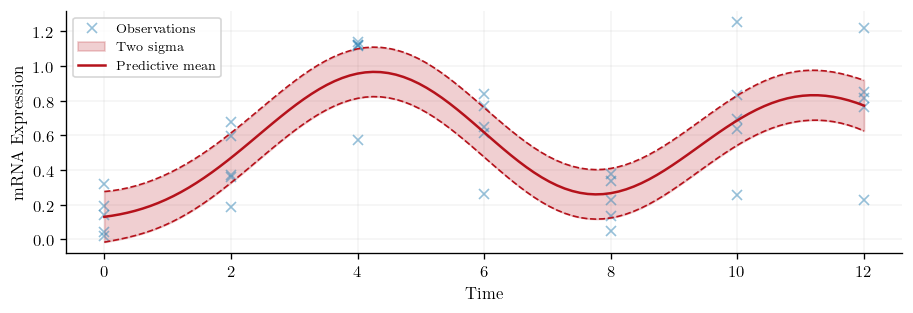

In [7]:
run_GPR_and_plot(mean_zero, rbf_kernel)

Optimization terminated successfully.
         Current function value: 7.767147
         Iterations: 34
         Function evaluations: 44
         Gradient evaluations: 44


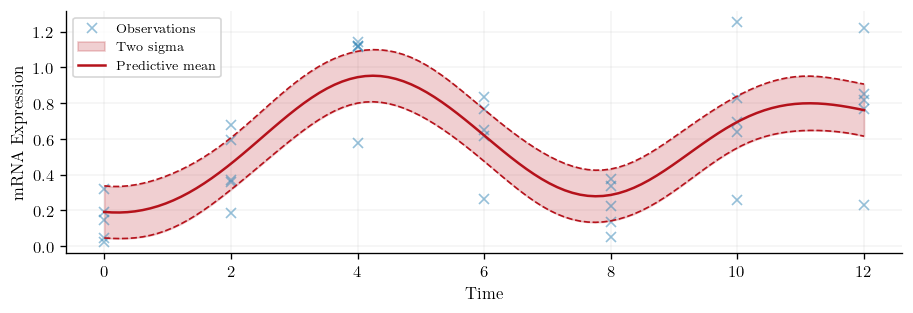

In [8]:
mean_const = gpx.mean_functions.Constant(20.0)
run_GPR_and_plot(mean_const, rbf_kernel)

In [9]:
# Testing custom mean function with linear mean function
import tensorflow_probability.substrates.jax.bijectors as tfb
from dataclasses import dataclass
from beartype.typing import Union
import jax.numpy as jnp
from gpjax.base import param_field
from gpjax.typing import Array
from gpjax.mean_functions import AbstractMeanFunction
from jaxtyping import (
    Float,
    Num,
)

from gpjax.typing import (
    Array,
    ScalarFloat,
    Int,
)

from gpjax.base import (
    Module,
    param_field,
    static_field,
)

@dataclass
class LinearMeanFunction(AbstractMeanFunction):
    slope: Array = param_field(jnp.array([1.0]))  # Default slope is 1.0
    intercept: Array = param_field(jnp.array([0.0]))  # Default intercept is 0.0

    def __call__(self, x: Array) -> Array:
        r"""Evaluate the linear mean function at the given points.

        Args:
            x (Array): The points at which to evaluate the mean function.

        Returns
        -------
            Array: The evaluated mean function.
        """
        mean = self.slope * x + self.intercept
        print(mean.shape, x.shape)
        if x.shape == (100,1):
            global linear_means_100 
            linear_means_100 = x 
        return mean

In [10]:
@dataclass
class Constant(AbstractMeanFunction):
    r"""Constant mean function.

    A constant mean function. This function returns a repeated scalar value for all
    inputs.  The scalar value itself can be treated as a model hyperparameter and
    learned during training but defaults to 1.0.
    """

    constant: Float[Array, " O"] = param_field(jnp.array([0.0]))

    def __call__(self, x: Num[Array, "N D"]) -> Float[Array, "N O"]:
        r"""Evaluate the mean function at the given points.

        Args:
            x (Float[Array, " D"]): The point at which to evaluate the mean function.

        Returns
        -------
            Float[Array, "1"]: The evaluated mean function.
        """
        mean = jnp.ones((x.shape[0], 1)) * self.constant
        print(mean.shape, x.shape)
        if x.shape == (100,1):
            global const_mean_100
            const_mean_100 = x
            print(x)  
        return mean

In [11]:
linear_mean = LinearMeanFunction(slope=jnp.array([7.0]), intercept=jnp.array([10.0]))


prior = gpx.gps.Prior(rbf_kernel, linear_mean)
likelihood = gpx.likelihoods.Gaussian(num_datapoints=p53_gpjax_dataset.n)
posterior = prior * likelihood
negative_mll = gpx.objectives.ConjugateMLL(negative=True)
negative_mll(posterior, train_data=p53_gpjax_dataset)
#negative_mll = jit(negative_mll)

opt_posterior, history = gpx.fit_scipy(
model=posterior,
objective=negative_mll,
train_data=p53_gpjax_dataset,
verbose = True)

latent_dist = opt_posterior.predict(x_test, train_data=p53_gpjax_dataset)
predictive_dist = opt_posterior.likelihood(latent_dist)

predictive_mean = predictive_dist.mean()
predictive_std = predictive_dist.variance()

(35, 1) (35, 1)
(35, 1) (35, 1)
Optimization terminated successfully.
         Current function value: 7.177198
         Iterations: 76
         Function evaluations: 85
         Gradient evaluations: 85
(35, 1) (35, 1)
(100, 1) (100, 1)


In [12]:
linear_mean = LinearMeanFunction(slope=jnp.array([7.0]), intercept=jnp.array([10.0]))
const_mean = Constant(constant=jnp.array([20.0]))

prior = gpx.gps.Prior(rbf_kernel, const_mean)
likelihood = gpx.likelihoods.Gaussian(num_datapoints=p53_gpjax_dataset.n)
posterior = prior * likelihood
negative_mll = gpx.objectives.ConjugateMLL(negative=True)
negative_mll(posterior, train_data=p53_gpjax_dataset)
#negative_mll = jit(negative_mll)

opt_posterior, history = gpx.fit_scipy(
model=posterior,
objective=negative_mll,
train_data=p53_gpjax_dataset,
verbose = True)

latent_dist = opt_posterior.predict(x_test, train_data=p53_gpjax_dataset)
predictive_dist = opt_posterior.likelihood(latent_dist)

predictive_mean = predictive_dist.mean()
predictive_std = predictive_dist.variance()

(35, 1) (35, 1)
(35, 1) (35, 1)
Optimization terminated successfully.
         Current function value: 7.767147
         Iterations: 34
         Function evaluations: 44
         Gradient evaluations: 44
(35, 1) (35, 1)
(100, 1) (100, 1)
[[ 0.        ]
 [ 0.12121212]
 [ 0.24242424]
 [ 0.36363636]
 [ 0.48484848]
 [ 0.60606061]
 [ 0.72727273]
 [ 0.84848485]
 [ 0.96969697]
 [ 1.09090909]
 [ 1.21212121]
 [ 1.33333333]
 [ 1.45454545]
 [ 1.57575758]
 [ 1.6969697 ]
 [ 1.81818182]
 [ 1.93939394]
 [ 2.06060606]
 [ 2.18181818]
 [ 2.3030303 ]
 [ 2.42424242]
 [ 2.54545455]
 [ 2.66666667]
 [ 2.78787879]
 [ 2.90909091]
 [ 3.03030303]
 [ 3.15151515]
 [ 3.27272727]
 [ 3.39393939]
 [ 3.51515152]
 [ 3.63636364]
 [ 3.75757576]
 [ 3.87878788]
 [ 4.        ]
 [ 4.12121212]
 [ 4.24242424]
 [ 4.36363636]
 [ 4.48484848]
 [ 4.60606061]
 [ 4.72727273]
 [ 4.84848485]
 [ 4.96969697]
 [ 5.09090909]
 [ 5.21212121]
 [ 5.33333333]
 [ 5.45454545]
 [ 5.57575758]
 [ 5.6969697 ]
 [ 5.81818182]
 [ 5.93939394]
 [ 6.0606060

(35, 1) (35, 1)
(35, 1) (35, 1)
Optimization terminated successfully.
         Current function value: 7.177198
         Iterations: 76
         Function evaluations: 85
         Gradient evaluations: 85
(35, 1) (35, 1)
(100, 1) (100, 1)


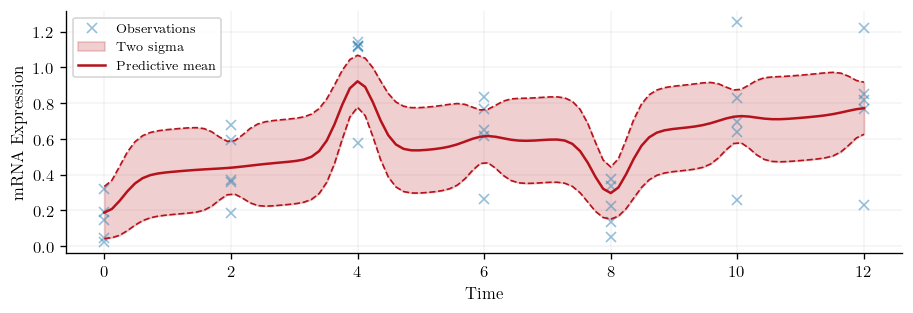

In [14]:
linear_mean = LinearMeanFunction(slope=jnp.array([7.0]), intercept=jnp.array([10.0]))
run_GPR_and_plot(linear_mean, rbf_kernel)

### Custom mean function

The mean function for the gene expressions per time is used to obtain the basal rates:

$$
f(x_{j}) = \frac{B_{j}}{D_{j}} 
$$

In [16]:
num_genes = p53_data.num_outputs

In [17]:
decay_rates = jnp.array(params_ground_truth()[-1])

@dataclass
class SIMmean(AbstractMeanFunction):
    r"""
    Simple Input Motif mean function

    ```math
        f(x_{j}) = \frac{B_{j}}{D_{j}} 
    ```

    From equation 2 in paper.

    $B_{j}$ represents the basal rate for gene $j$ and is a trainable paramater.
    """
    # TODO: figure out how to get this from data
    num_genes: Int[Int, " O"] = static_field(num_genes, init=False)

    # default value, contraint (positive)
    basal_rates: Array = param_field(jnp.array([0.05, 0.05, 0.05, 0.05, 0.05], dtype=jnp.float32), bijector=tfb.Softplus())

    def __call__(self, t: Num[Array, "N D"]) -> Float[Array, "N O"]:
        r"""Evaluate the mean function for gene expression at the given points in time.

        Parameters:
        ------------
            x : (Float[Array, " D"])
                The timepoints at which to evaluate the mean function.

        Returns:
        ---------
            Float[Array, "1"]
                The evaluated mean function at that point in time
        """
        # Note this will only work with 5 genes as this is hardcoded
        block_size = t.shape[0] // self.num_genes
        mean = (self.basal_rates).reshape(-1,1)
        mean = jnp.repeat(mean, block_size, axis=1).reshape(-1,1)


        return mean

In [15]:
@dataclass
class SIMTesting(AbstractMeanFunction):
    b: Array = param_field(jnp.array([0.05, 0.05, 0.05, 0.05, 0.05], dtype=jnp.float32), bijector=tfb.Softplus())

    num_genes: Int[Int, " O"] = static_field(5, init=False)
    def __call__(self, t: Array) -> Array:
        r"""Evaluate the linear mean function at the given points.

        Args:
            x (Array): The points at which to evaluate the mean function.

        Returns
        -------
            Array: The evaluated mean function.
        """

        block_size = int(t.shape[0] // self.num_genes)

        mean = jnp.repeat(self.b, block_size, axis=0).reshape(-1,1)
        return mean

In [16]:
custom_mean = SIMTesting()

prior = gpx.gps.Prior(rbf_kernel, custom_mean)
likelihood = gpx.likelihoods.Gaussian(num_datapoints=p53_gpjax_dataset.n)
posterior = prior * likelihood
negative_mll = gpx.objectives.ConjugateMLL(negative=True)

negative_mll(posterior, train_data=p53_gpjax_dataset)

opt_posterior, history = gpx.fit_scipy(
model=posterior,
objective=negative_mll,
train_data=p53_gpjax_dataset,
verbose = True)

Optimization terminated successfully.
         Current function value: -1.302452
         Iterations: 46
         Function evaluations: 71
         Gradient evaluations: 71


In [18]:
custom_mean = SIMmean()

prior = gpx.gps.Prior(rbf_kernel, custom_mean)
likelihood = gpx.likelihoods.Gaussian(num_datapoints=p53_gpjax_dataset.n)
posterior = prior * likelihood
negative_mll = gpx.objectives.ConjugateMLL(negative=True)
negative_mll(posterior, train_data=p53_gpjax_dataset)

#negative_mll = jit(negative_mll)

opt_posterior, history = gpx.fit_scipy(
model=posterior,
objective=negative_mll,
train_data=p53_gpjax_dataset,
verbose = True)

latent_dist = opt_posterior.predict(x_test, train_data=p53_gpjax_dataset)
predictive_dist = opt_posterior.likelihood(latent_dist)

predictive_mean = predictive_dist.mean()
predictive_std = predictive_dist.variance()


Optimization terminated successfully.
         Current function value: -11.174890
         Iterations: 47
         Function evaluations: 88
         Gradient evaluations: 88


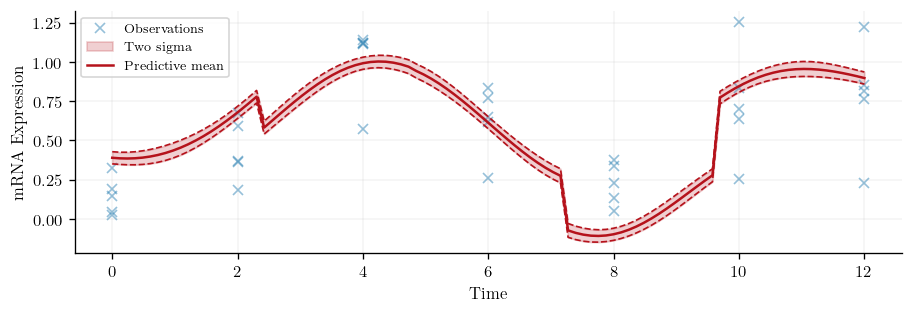

In [19]:
plot_GP(predictive_mean, predictive_std)